In [1]:
!pip install -q transformers
!pip install pydot
!pip install tensorflow==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorf

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from transformers import BertTokenizer, TFBertModel
model_checkpoint = 'bert-base-cased'

In [4]:
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def cm(preds, true_label):
  t = {0:'anger', 1:'fear', 2:'joy', 3:'love', 4:'neutral', 5:'sadness', 6:'surprise'}
  cm = confusion_matrix(true_label, preds)
  plt.figure(figsize=(10,7))
  sns.heatmap(
      cm, annot=True, xticklabels=t.values(),
        yticklabels=t.values())
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

In [10]:
max_length = 200

####  Standardized BERT model (selected after tuning hidden dimension size) to try out with all different sizes

In [6]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 7,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              
    max_length = 200
    bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}    
    bert_out = bert_model(bert_inputs)
    cls_token = bert_out[0][:, 0, :]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden) 
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy') 
    return classification_model

In [7]:
bert_model = create_bert_multiclass_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 200)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 200)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 200)]       0           []                               
 er)                                                                                              
                                                                                              

###  Phase 2: Test for optimal training data size for BERT

#### Size = 17 k rows

In [10]:
train = pd.read_csv('train_data_imbalanced_stratified_no_dupe_17k_5k.csv')
val = pd.read_csv("validation_data_imbalanced_stratified_no_dupe_17k_5k.csv")
test = pd.read_csv("test_data_imbalanced_stratified_no_dupe.csv")

In [11]:
train_text = train['text'].tolist()
val_text = val['text'].tolist()
test_text = test['text'].tolist()


In [12]:
train_encodings = bert_tokenizer(train_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(val_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

In [13]:
nptrain_labels = np.asarray(train['emotions'])
npval_labels = np.asarray(val['emotions'])
nptest_labels = np.asarray(test['emotions'])

In [15]:
train_labels = pd.Categorical(train['emotions']).codes
npval_labels = pd.Categorical(val['emotions']).codes
nptest_labels = pd.Categorical(test['emotions']).codes

In [25]:
bert_model_17 = bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npval_labels),    
                                                  batch_size=8, 
                                                  epochs=2)  

Epoch 1/2


2136/2136 [==============================] - 863s 380ms/step - loss: 0.2740 - accuracy: 0.9197 - val_loss: 0.0896 - val_accuracy: 0.9742
Epoch 2/2
2136/2136 [==============================] - 803s 376ms/step - loss: 0.0879 - accuracy: 0.9742 - val_loss: 0.1221 - val_accuracy: 0.9688


In [26]:
predictions = bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)


1187/1187 [==============================] - 512s 429ms/step


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5226
           1       0.92      0.95      0.94      3955
           2       0.97      0.99      0.98     12917
           3       0.97      0.99      0.98      2434
           4       0.98      0.98      0.98       860
           5       0.99      0.94      0.97     11587
           6       0.98      0.96      0.97       982

    accuracy                           0.97     37961
   macro avg       0.96      0.97      0.97     37961
weighted avg       0.97      0.97      0.97     37961



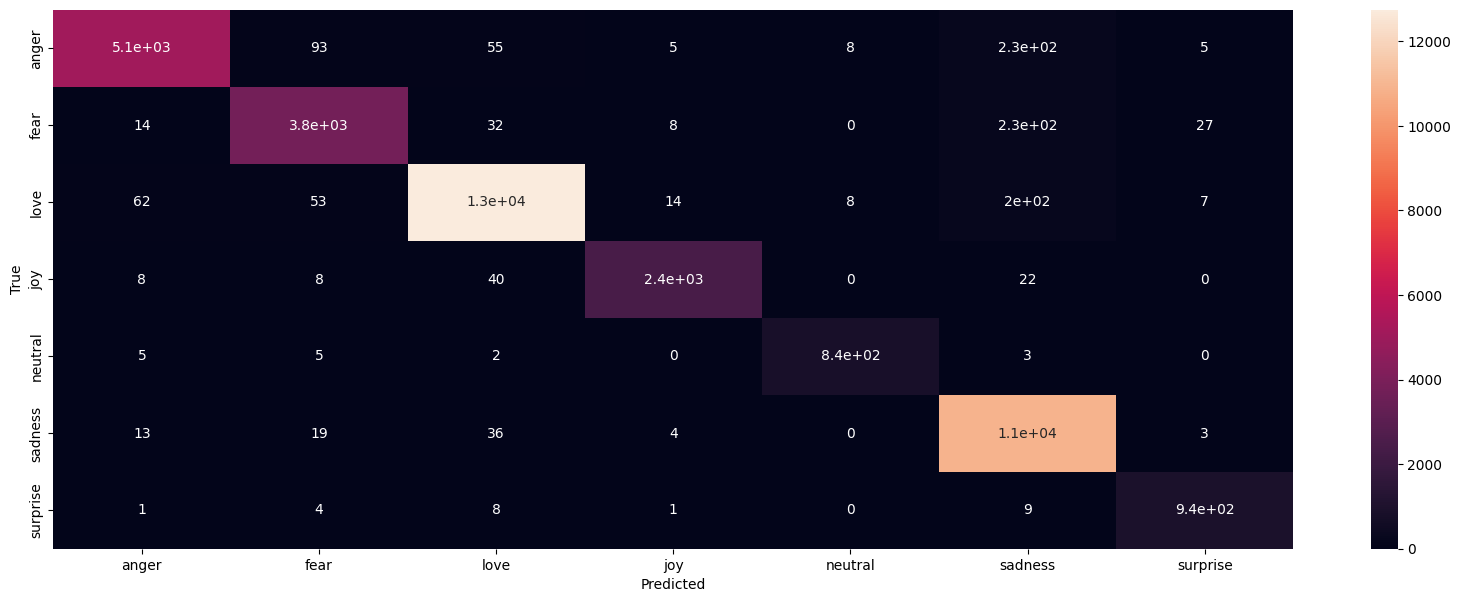

In [27]:
print(classification_report(nptest_labels, predictions.numpy()))
cm(nptest_labels, predictions.numpy())

#### Size = 34 k training rows

In [ ]:
#test with 34k
train = pd.read_csv('train_data_imbalanced_stratified_no_dupe_34k_10k.csv')
#lexicon = pd.read_csv("lexicon_220306.csv")
val = pd.read_csv("validation_data_imbalanced_stratified_no_dupe_34k_10k.csv")
test = pd.read_csv("test_data_imbalanced_stratified_no_dupe.csv")

In [ ]:
train_text = train['text'].tolist()
val_text = val['text'].tolist()
test_text = test['text'].tolist()


train_encodings = bert_tokenizer(train_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(val_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

In [ ]:
train_labels = pd.Categorical(train['emotions']).codes
npval_labels = pd.Categorical(val['emotions']).codes
nptest_labels = pd.Categorical(test['emotions']).codes

In [ ]:
bert_model_34k_history = bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npval_labels),    
                                                  batch_size=8, 
                                                  epochs=2)  

Epoch 1/2


4271/4271 [==============================] - 1717s 391ms/step - loss: 0.1914 - accuracy: 0.9436 - val_loss: 0.1033 - val_accuracy: 0.9700
Epoch 2/2
4271/4271 [==============================] - 1655s 388ms/step - loss: 0.0847 - accuracy: 0.9766 - val_loss: 0.0813 - val_accuracy: 0.9783


In [ ]:
predictions = bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(nptest_labels, predictions.numpy()))

1187/1187 [==============================] - 521s 437ms/step
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5226
           1       0.98      0.96      0.97      3955
           2       0.99      0.99      0.99     12917
           3       0.99      0.95      0.97      2434
           4       0.97      0.98      0.97       860
           5       0.99      0.98      0.98     11587
           6       0.97      0.90      0.93       982

    accuracy                           0.98     37961
   macro avg       0.97      0.96      0.97     37961
weighted avg       0.98      0.98      0.98     37961



#### Size = 68 k training rows

In [ ]:
#try with 68 k
train = pd.read_csv('train_data_imbalanced_stratified_no_dupe_68k_20k.csv')
#lexicon = pd.read_csv("lexicon_220306.csv")
val = pd.read_csv("validation_data_imbalanced_stratified_no_dupe_68k_20k.csv")
test = pd.read_csv("test_data_imbalanced_stratified_no_dupe.csv")

In [ ]:
train_text = train['text'].tolist()
val_text = val['text'].tolist()
test_text = test['text'].tolist()


train_encodings = bert_tokenizer(train_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(val_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

In [ ]:
train_labels = pd.Categorical(train['emotions']).codes
npval_labels = pd.Categorical(val['emotions']).codes
nptest_labels = pd.Categorical(test['emotions']).codes

In [ ]:
bert_model_68 = bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npval_labels),    
                                                  batch_size=8, 
                                                  epochs=2)  

Epoch 1/2
8541/8541 [==============================] - 3244s 380ms/step - loss: 0.0850 - accuracy: 0.9760 - val_loss: 0.0666 - val_accuracy: 0.9836
Epoch 2/2
 569/8541 [>.............................] - ETA: 45:03 - loss: 0.1144 - accuracy: 0.9697

In [ ]:
predictions = bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(nptest_labels, predictions.numpy()))

We see that using the 17k training size is enough for our purposes. We will use this for all other experiments.

### Phase 2: Experimentation with Lexicon with BERT Model

#### Filtering out training set to only include words in Lexicon.

In [28]:
from nltk import WhitespaceTokenizer
from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()
def stringify(text):
  finallist = ''
  for i in range(len(text)):
    if i + 1 == len(text):
      finallist += text[i]
    else:
      finallist += text[i] + ' '
  return finallist

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

def tokenizer(text):
  return w_tokenizer.tokenize(text)


In [30]:
#now doing a lexiconned version
train = pd.read_csv('train_data_imbalanced_stratified_no_dupe_17k_5k.csv')
val = pd.read_csv("validation_data_imbalanced_stratified_no_dupe_17k_5k.csv")
test = pd.read_csv("test_data_imbalanced_stratified_no_dupe.csv")
lexicon = pd.read_csv("lexicon_220306.csv")
lexicon_word_list  = lexicon['cleaned_stopwords'].tolist()


In [31]:
train['tokenized'] = train['text'].apply(tokenizer)
train['lexiconned'] = train['tokenized'].apply(lambda x: [word for word in x if word in (lexicon_word_list)])

In [32]:
test['tokenized'] = test['text'].apply(tokenizer)
test['lexiconned'] = test['tokenized'].apply(lambda x: [word for word in x if word in (lexicon_word_list)])
val['tokenized'] = val['text'].apply(tokenizer)
val['lexiconned'] = val['tokenized'].apply(lambda x: [word for word in x if word in (lexicon_word_list)])


In [ ]:
train

,Unnamed: 0,text,emotions,tokenized,lexiconned
0,353338,i feel so repressed with this one now,sadness,"[i, feel, so, repressed, with, this, one, now]",[repressed]
1,93908,im feeling very thankful this evening for many...,joy,"[im, feeling, very, thankful, this, evening, f...",[thankful]
2,255061,i would not feel so dismayed everybody must ge...,sadness,"[i, would, not, feel, so, dismayed, everybody,...",[dismayed]
3,302497,i feel like i m rich in that department,joy,"[i, feel, like, i, m, rich, in, that, department]",[rich]
4,387425,ill sink again a time or two before i can real...,joy,"[ill, sink, again, a, time, or, two, before, i...",[peaceful]
...,...,...,...,...,...
17077,207605,i to feel angry and pissed when everything is ...,anger,"[i, to, feel, angry, and, pissed, when, everyt...",[pissed]
17078,419381,@oyfreakinvey rofl,neutral,"[@oyfreakinvey, rofl]",[]
17079,136521,ive thought about killing myself so i wouldnt ...,sadness,"[ive, thought, about, killing, myself, so, i, ...","[vain, selfish, unattractive]"
17080,15541,i feel eager to get started,joy,"[i, feel, eager, to, get, started]",[eager]


In [33]:
train['stringed'] = train['lexiconned'].apply(stringify)
test['stringed']= test['lexiconned'].apply(stringify)
val['stringed'] = val['lexiconned'].apply(stringify)
train_x = train['stringed']
train_y = train['emotions']
val_x = val['stringed']
val_y = val['emotions']
test_x = test['stringed']
test_y = test['emotions']

In [34]:
train_labels = pd.Categorical(train_y).codes
npval_labels = pd.Categorical(val_y).codes
nptest_labels = pd.Categorical(test_y).codes

In [35]:
train_text = train_x.tolist()
val_text = val_x.tolist()
test_text = test_x.tolist()
max_length = 200

In [36]:
train_encodings = bert_tokenizer(train_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(val_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

In [37]:
bert_model_lexicon = bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npval_labels),    
                                                  batch_size=8, 
                                                  epochs=2) 

Epoch 1/2
2136/2136 [==============================] - 807s 378ms/step - loss: 0.2770 - accuracy: 0.9083 - val_loss: 0.2269 - val_accuracy: 0.9130
Epoch 2/2
2136/2136 [==============================] - 797s 373ms/step - loss: 0.2606 - accuracy: 0.9121 - val_loss: 0.2334 - val_accuracy: 0.9099


1187/1187 [==============================] - 507s 427ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      0.88      0.92      5226
           1       0.94      0.93      0.94      3955
           2       0.82      0.97      0.89     12917
           3       0.96      0.92      0.93      2434
           4       0.00      0.00      0.00       860
           5       0.97      0.90      0.93     11587
           6       0.94      0.95      0.95       982

    accuracy                           0.91     37961
   macro avg       0.80      0.79      0.79     37961
weighted avg       0.89      0.91      0.90     37961



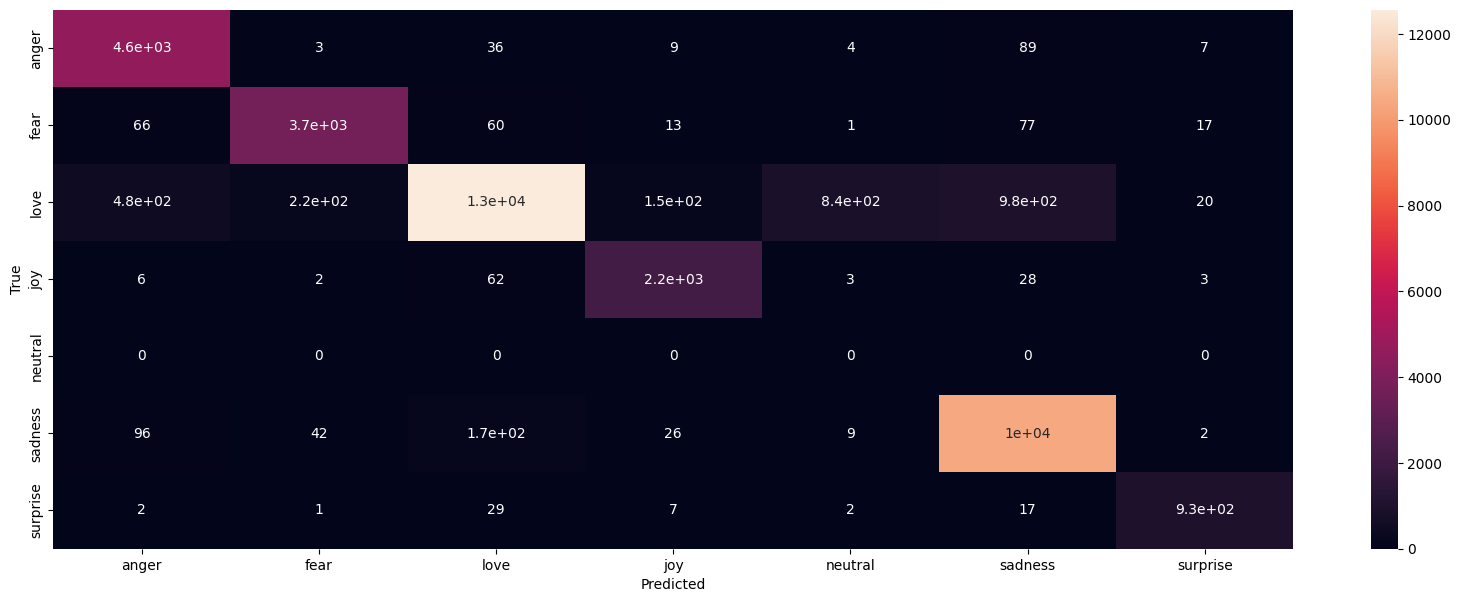

In [38]:
predictions = bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(nptest_labels, predictions.numpy()))
cm(nptest_labels, predictions.numpy())

#### Filter out training set to only include words NOT in Lexicon

In [39]:
train = pd.read_csv('train_data_imbalanced_stratified_no_dupe_17k_5k.csv')
val = pd.read_csv("validation_data_imbalanced_stratified_no_dupe_17k_5k.csv")
test = pd.read_csv("test_data_imbalanced_stratified_no_dupe.csv")
lexicon = pd.read_csv("lexicon_220306.csv")
lexicon_word_list  = lexicon['cleaned_stopwords'].tolist()

In [40]:
# now only words not in lexicon
train['tokenized'] = train['text'].apply(tokenizer)
train['lexiconned'] = train['tokenized'].apply(lambda x: [word for word in x if word not in (lexicon_word_list)])

In [41]:
test['tokenized'] = test['text'].apply(tokenizer)
test['lexiconned'] = test['tokenized'].apply(lambda x: [word for word in x if word not in (lexicon_word_list)])
val['tokenized'] = val['text'].apply(tokenizer)
val['lexiconned'] = val['tokenized'].apply(lambda x: [word for word in x if word not in (lexicon_word_list)])


In [42]:
train['stringed'] = train['lexiconned'].apply(stringify)
test['stringed']= test['lexiconned'].apply(stringify)
val['stringed'] = val['lexiconned'].apply(stringify)
train_x = train['stringed']
train_y = train['emotions']
val_x = val['stringed']
val_y = val['emotions']
test_x = test['stringed']
test_y = test['emotions']

In [43]:
train_labels = pd.Categorical(train_y).codes
npval_labels = pd.Categorical(val_y).codes
nptest_labels = pd.Categorical(test_y).codes

In [44]:
train_text = train_x.tolist()
val_text = val_x.tolist()
test_text = test_x.tolist()

In [45]:
train_encodings = bert_tokenizer(train_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(val_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

In [46]:
bert_model_reverse_lexicon = bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npval_labels),    
                                                  batch_size=8, 
                                                  epochs=2) 

Epoch 1/2
2136/2136 [==============================] - 802s 376ms/step - loss: 1.4371 - accuracy: 0.4429 - val_loss: 1.3519 - val_accuracy: 0.4786
Epoch 2/2
2136/2136 [==============================] - 798s 374ms/step - loss: 1.2700 - accuracy: 0.5283 - val_loss: 1.3433 - val_accuracy: 0.4855


1187/1187 [==============================] - 510s 429ms/step
              precision    recall  f1-score   support

           0       0.51      0.19      0.28      5226
           1       0.34      0.17      0.23      3955
           2       0.53      0.66      0.59     12917
           3       0.41      0.13      0.20      2434
           4       1.00      0.97      0.98       860
           5       0.45      0.63      0.53     11587
           6       0.67      0.00      0.00       982

    accuracy                           0.49     37961
   macro avg       0.56      0.39      0.40     37961
weighted avg       0.49      0.49      0.46     37961



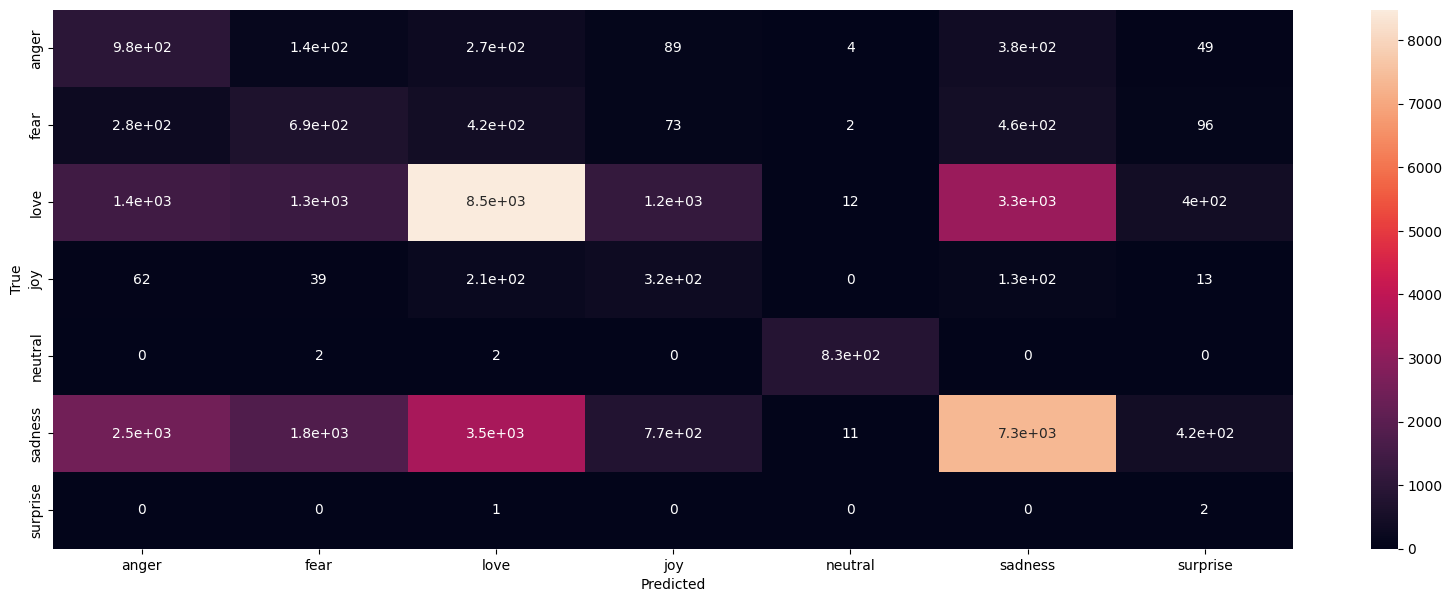

In [47]:
predictions = bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(nptest_labels, predictions.numpy()))
cm(nptest_labels, predictions.numpy())

#### Phase 2: Test best BERT model on Kaggle data set

In [11]:
 #test with new data set with no lexicon
train = pd.read_csv('train_data_imbalanced_stratified_no_dupe_17k_5k.csv')
val = pd.read_csv("validation_data_imbalanced_stratified_no_dupe_17k_5k.csv")
test = pd.read_csv("kaggle_data_no_dupe.csv")
train_text = train['text'].tolist()
val_text = val['text'].tolist()
test_text = test['text'].tolist()

train_encodings = bert_tokenizer(train_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(val_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')


In [12]:
train_labels = pd.Categorical(train['emotions']).codes
npval_labels = pd.Categorical(val['emotions']).codes
nptest_labels = pd.Categorical(test['emotions']).codes

In [13]:
bert_model_kaggle = bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npval_labels),    
                                                  batch_size=8, 
                                                  epochs=2) 

Epoch 1/2


2136/2136 [==============================] - 849s 373ms/step - loss: 0.2767 - accuracy: 0.9165 - val_loss: 0.1329 - val_accuracy: 0.9660
Epoch 2/2
2136/2136 [==============================] - 786s 368ms/step - loss: 0.0920 - accuracy: 0.9744 - val_loss: 0.0711 - val_accuracy: 0.9817


619/619 [==============================] - 264s 421ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.01      0.01      0.01       110
           1       0.06      0.00      0.00      3770
           2       0.15      0.00      0.00      8580
           3       0.21      0.00      0.00      5142
           4       0.11      0.99      0.20      2177
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.11     19779
   macro avg       0.08      0.14      0.03     19779
weighted avg       0.15      0.11      0.02     19779



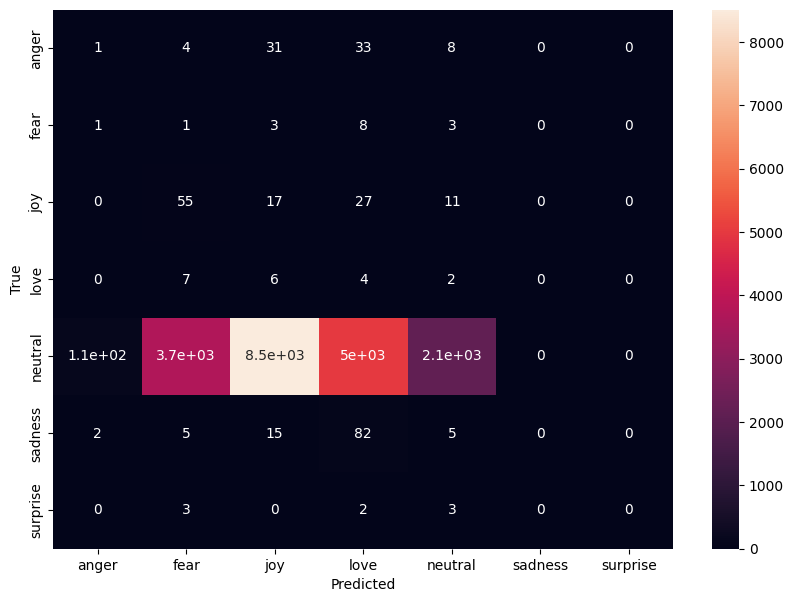

In [14]:
predictions = bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(nptest_labels, predictions.numpy()))
cm(nptest_labels, predictions.numpy())

#### Test on balanced clean test set

In [15]:
test = pd.read_csv("test_data_balanced_no_dupe.csv")
test_text = test['text'].tolist()
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
nptest_labels = pd.Categorical(test['emotions']).codes

189/189 [==============================] - 79s 419ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       860
           1       0.95      0.98      0.96       860
           2       0.96      0.99      0.98       860
           3       1.00      0.97      0.98       860
           4       0.98      0.99      0.99       860
           5       0.98      0.99      0.99       860
           6       0.99      0.97      0.98       860

    accuracy                           0.98      6020
   macro avg       0.98      0.98      0.98      6020
weighted avg       0.98      0.98      0.98      6020



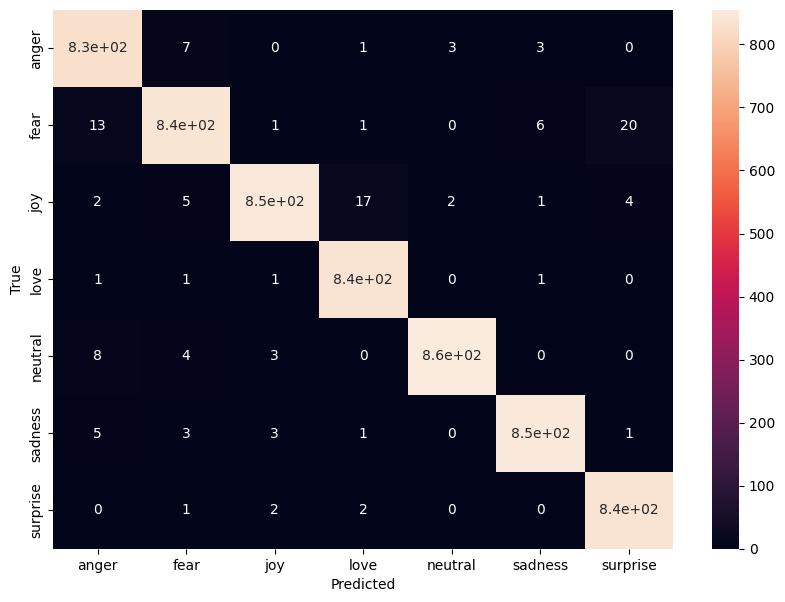

In [16]:
predictions = bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(nptest_labels, predictions.numpy()))
cm(nptest_labels, predictions.numpy())

### Phase 3: Create combined training set with CARER and Kaggle data, test on BERT architecture

In [18]:
#try a new bert with mixed kaggle and clean set with squished labeles
train_mix = pd.read_csv("train_20k_12k_mixed_strat_clean_kaggle_230404.csv")
val_mix = pd.read_csv("validation_20k_12k_mixed_strat_clean_kaggle_230404.csv")
test_mix = pd.read_csv("test_data_imbalanced_stratified_no_dupe.csv")

In [19]:
dupes = pd.merge(train_mix, test_mix, on='text')
to_drop = train_mix['text'].isin(dupes['text'])
train_mix = train_mix[~to_drop]
train_mix.shape

(20324, 3)

In [20]:
train_text = train_mix['text'].tolist()
val_text = val_mix['text'].tolist()
test_text = test_mix['text'].tolist()

train_encodings = bert_tokenizer(train_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(val_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')


In [21]:
train_labels = pd.Categorical(train_mix['emotions']).codes
npval_labels = pd.Categorical(val_mix['emotions']).codes
nptest_labels = pd.Categorical(test_mix['emotions']).codes

In [22]:
bert_model_mix = bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npval_labels),    
                                                  batch_size=8, 
                                                  epochs=2) 

Epoch 1/2
2541/2541 [==============================] - 1045s 411ms/step - loss: 0.8717 - accuracy: 0.6688 - val_loss: 0.8156 - val_accuracy: 0.6828
Epoch 2/2
2541/2541 [==============================] - 1044s 411ms/step - loss: 0.8177 - accuracy: 0.6857 - val_loss: 0.8040 - val_accuracy: 0.6863


1187/1187 [==============================] - 496s 418ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5226
           1       0.84      0.99      0.90      3955
           2       0.96      0.98      0.97     12917
           3       0.96      0.99      0.97      2434
           4       0.85      0.15      0.26       860
           5       0.99      0.97      0.98     11587
           6       0.97      0.96      0.97       982

    accuracy                           0.96     37961
   macro avg       0.94      0.86      0.86     37961
weighted avg       0.96      0.96      0.95     37961



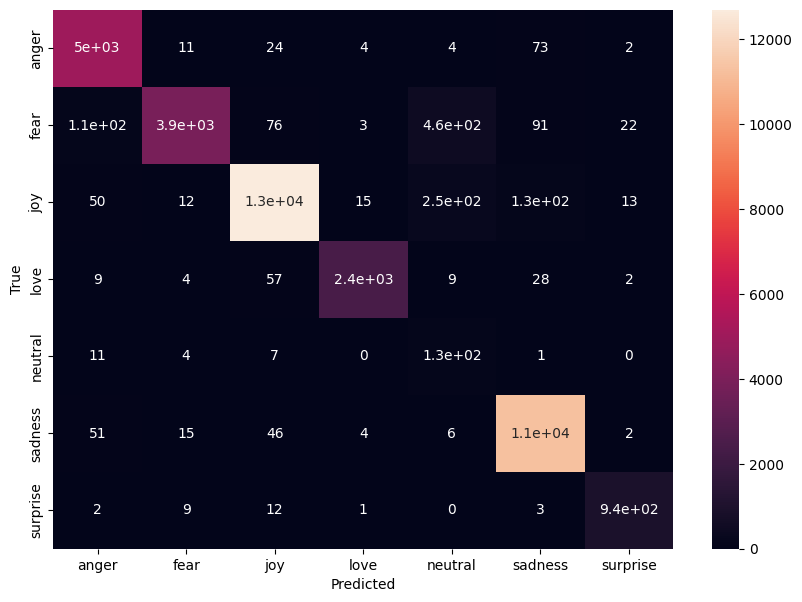

In [23]:
predictions = bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(nptest_labels, predictions.numpy()))
cm(nptest_labels, predictions.numpy())

### Now let's see if Bert can tell the different between the kaggle and clean data sources. (Needs tuning)

In [ ]:
def create_bert_model(max_sequence_length=200,
                          hidden_size = 50, 
                          dropout=0.3,
                          learning_rate=0.00005):
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(200,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)
    cls_token = bert_out[0][:, 0, :]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden) 
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification]) 
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    return classification_model

In [ ]:
train_mix = pd.read_csv("train_source_20k_12k_mixed_230404.csv")
test_mix = pd.read_csv("validation_source_20k_12k_mixed_230404.csv")

In [ ]:
train_mix.head()

,Unnamed: 0,text,source
0,12353,i realize is often the case when people have a...,clean
1,24385,Roll on Thursday,unclean
2,5133,Booo. Finally I could get back on here. My Int...,unclean
3,21625,i be able to feel be joyful whatever the circu...,clean
4,1397,i feel like ive been melancholy lately for a l...,clean


In [ ]:
train_text = train_mix['text'].tolist()
#val_text = val['text'].tolist()
test_text = test_mix['text'].tolist()

train_encodings = bert_tokenizer(train_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
#valid_encodings = bert_tokenizer(val_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_text, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')


In [ ]:
train_labels = pd.Categorical(train_mix['source']).codes
#npval_labels = pd.Categorical(val['emotions']).codes
nptest_labels = pd.Categorical(test_mix['source']).codes

In [ ]:
print(train_encodings)

{'input_ids': <tf.Tensor: shape=(20535, 200), dtype=int32, numpy=
array([[ 101,  178, 4663, ...,    0,    0,    0],
       [ 101, 9916, 1113, ...,    0,    0,    0],
       [ 101, 9326, 5658, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1145, ...,    0,    0,    0],
       [ 101, 1109, 2255, ...,    0,    0,    0],
       [ 101, 1188, 2669, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(20535, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(20535, 200), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [ ]:
bert_model_source = create_bert_cls_model()


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_source_model_history = bert_model_source.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
    train_labels, validation_data=([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
    nptest_labels), batch_size=8, epochs=2) 

Epoch 1/2


2567/2567 [==============================] - 1111s 418ms/step - loss: 0.0275 - accuracy: 0.9929 - val_loss: 0.0189 - val_accuracy: 0.9961
Epoch 2/2
2567/2567 [==============================] - 1063s 414ms/step - loss: 0.2162 - accuracy: 0.8802 - val_loss: 0.6923 - val_accuracy: 0.5285
